In [ ]:
# load libraries used in this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# functions that we will use in this notebook that you don;t need to worry about for now

def get_daily_wrds_single_ticker(ticker,conn,dividends=True):
    tickers = [ticker]
    # Retrieve PERMNOs for the specified tickers
    permnos = conn.get_table(library='crsp', table='stocknames', columns=['permno', 'ticker', 'namedt', 'nameenddt'])
    permnos['nameenddt']=pd.to_datetime(permnos['nameenddt'])
    permnos = permnos[(permnos['ticker'].isin(tickers)) & (permnos['nameenddt']==permnos['nameenddt'].max())]
    # Extract unique PERMNOs
    permno_list = [permnos['permno'].unique().tolist()[0]]
    print(permno_list)

    # Query daily stock file for the specified PERMNOs
    query = f"""
        SELECT permno, date, ret, retx, prc
        FROM crsp.dsf
        WHERE permno IN ({','.join(map(str, permno_list))})
        ORDER BY date
    """
    daily_returns = conn.raw_sql(query, date_cols=['date'])
    daily_returns = daily_returns.merge(permnos[['permno', 'ticker']], on='permno', how='left')
    # Pivot data to have dates as index and tickers as columns
    # daily_returns = daily_returns.pivot(index='date', columns='ticker', values='ret')
    # daily_returns=daily_returns['2000':]
    if dividends:
        daily_returns['D']=(daily_returns.ret-daily_returns.retx)*daily_returns.prc.abs().shift(1)
        daily_returns['P']=daily_returns.prc.abs()
        daily_returns=daily_returns[['date','P','D']].set_index('date').dropna()
    else:
        daily_returns=daily_returns[['date','ret']].set_index('date').dropna()


    return daily_returns

def get_daily_wrds(conn,tickers=None):

    # Retrieve PERMNOs for the specified tickers
    permnos = conn.get_table(library='crsp', table='stocknames', columns=['permno', 'ticker', 'namedt', 'nameenddt'])
    permnos['nameenddt']=pd.to_datetime(permnos['nameenddt'])
    permnos = permnos[(permnos['ticker'].isin(tickers)) & (permnos['nameenddt']==permnos['nameenddt'].max())]
    # Extract unique PERMNOs
    permno_list = permnos['permno'].unique().tolist()
    print(permno_list)

    # Query daily stock file for the specified PERMNOs

    query = f"""
        SELECT permno, date, ret, retx, prc
        FROM crsp.dsf
        WHERE permno IN ({','.join(map(str, permno_list))})
        ORDER BY date,permno
    """
    daily_returns = conn.raw_sql(query, date_cols=['date'])
    daily_returns = daily_returns.merge(permnos[['permno', 'ticker']], on='permno', how='left')
# Pivot data to have dates as index and tickers as columns
    daily_returns = daily_returns.pivot(index='date', columns='ticker', values='ret')
    daily_returns=daily_returns[tickers]

    return daily_returns

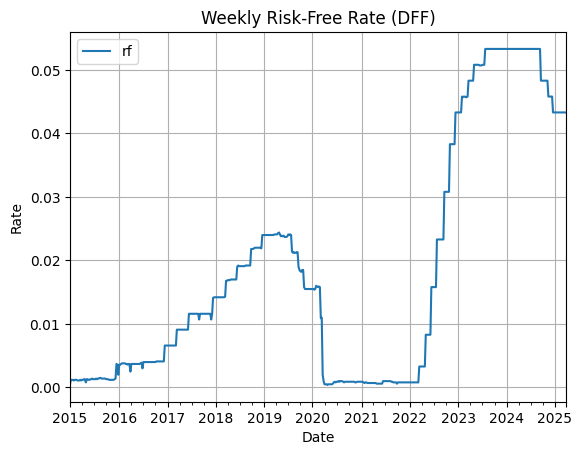

In [ ]:
from pandas_datareader.data import DataReader
import datetime

# Define the date range
start_date = datetime.datetime(2015,1,1)  # Start date (adjust as needed)
end_date = datetime.datetime(2025,3,25)          # End date


df_rf = DataReader("DFF", "fred", start_date, end_date)
df_rf.reset_index(inplace=True)
df_rf.columns = ["Date", "rf"]
df_rf.rf=df_rf.rf/100
df_rf.set_index("Date", inplace=True)

df_rf_weekly = df_rf.resample('W-THU').last()

# Plot the weekly data
df_rf_weekly.plot()
plt.title("Weekly Risk-Free Rate (DFF)")
plt.ylabel("Rate")
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd

CPI=pd.read_excel('T10YIE.xlsx',usecols='A:B')
CPI.dropna(inplace=True)
CPI.columns=['Date','rate']
CPI['Date'] = pd.to_datetime(CPI['Date'])
CPI.set_index('Date', inplace=True)
CPI=CPI.sort_index(ascending=False)
CPI.head()

,rate
Date,
2025-03-27,2.36
2025-03-20,2.30
2025-03-13,2.31
2025-03-06,2.35
2025-02-27,2.39


In [ ]:
df_rf_weekly_sorted = df_rf_weekly.sort_index(ascending=False)
df_rf_weekly_sorted.head()

,rf
Date,
2025-03-27,0.0433
2025-03-20,0.0433
2025-03-13,0.0433
2025-03-06,0.0433
2025-02-27,0.0433


In [ ]:
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd

sector1=pd.read_excel('Sector.xlsx',sheet_name='XLK',usecols='A:G')
sector1.dropna(inplace=True)
sector1['Date'] = pd.to_datetime(sector1['Date'])
sector1.set_index('Date', inplace=True)
sector1.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2025-03-27,212.02,213.22,210.39,211.51,211.51,3288900.0
2025-03-20,212.47,218.15,209.94,217.63,217.25,12885400.0
2025-03-13,211.07,217.43,206.85,214.91,214.53,26448900.0
2025-03-06,217.02,220.45,206.29,211.68,211.31,37535800.0
2025-02-27,232.26,232.50,214.26,221.57,221.18,33220200.0


In [ ]:
sector1['re'] = (sector1['Close'] - sector1['Close'].shift(1)) / sector1['Close'].shift(1)
sector1['re'].dropna(inplace=True)

sector1.head()

,Open,High,Low,Close,Adj Close,Volume,re
Date,,,,,,,
2025-03-27,212.02,213.22,210.39,211.51,211.51,3288900.0,NaN
2025-03-20,212.47,218.15,209.94,217.63,217.25,12885400.0,0.028935
2025-03-13,211.07,217.43,206.85,214.91,214.53,26448900.0,-0.012498
2025-03-06,217.02,220.45,206.29,211.68,211.31,37535800.0,-0.015030
2025-02-27,232.26,232.50,214.26,221.57,221.18,33220200.0,0.046721


In [ ]:
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd

sector2=pd.read_excel('Sector.xlsx',sheet_name='XLF',usecols='A:G')

sector2.dropna(inplace=True)
sector2['Date'] = pd.to_datetime(sector2['Date'])
sector2.set_index('Date', inplace=True)
sector2.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2025-03-27,50.19,50.45,49.79,50.18,50.18,32299800.0
2025-03-20,49.29,50.51,49.03,50.43,50.25,167730500.0
2025-03-13,47.8,49.83,47.28,49.57,49.39,220097400.0
2025-03-06,49.62,49.96,47.22,47.68,47.51,354722800.0
2025-02-27,51.03,52.64,49.56,50.21,50.03,358919900.0


In [ ]:
sector2['re'] = (sector2['Close'] - sector2['Close'].shift(1)) / sector2['Close'].shift(1)
sector2['re'].dropna(inplace=True)
sector2.head()

,Open,High,Low,Close,Adj Close,Volume,re
Date,,,,,,,
2025-03-27,50.19,50.45,49.79,50.18,50.18,32299800.0,NaN
2025-03-20,49.29,50.51,49.03,50.43,50.25,167730500.0,0.004982
2025-03-13,47.8,49.83,47.28,49.57,49.39,220097400.0,-0.017053
2025-03-06,49.62,49.96,47.22,47.68,47.51,354722800.0,-0.038128
2025-02-27,51.03,52.64,49.56,50.21,50.03,358919900.0,0.053062


In [ ]:
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd

sector3=pd.read_excel('Sector.xlsx',sheet_name='XLV',usecols='A:G')

sector3.dropna(inplace=True)
sector3['Date'] = pd.to_datetime(sector3['Date'])
sector3.set_index('Date', inplace=True)
sector3.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2025-03-27,144.52,145.42,144.46,144.97,144.97,6264300.0
2025-03-20,146.94,147.64,144.35,145.27,144.71,28671000.0
2025-03-13,144.66,147.31,143.41,146.92,146.35,32504300.0
2025-03-06,149,150.28,144.12,144.60,144.04,45785100.0
2025-02-27,147.55,150.32,146.49,149.68,149.10,43692400.0


In [ ]:
sector3['re'] = (sector3['Close'] - sector3['Close'].shift(1)) / sector3['Close'].shift(1)
sector3['re'].dropna(inplace=True)
sector3.head()

,Open,High,Low,Close,Adj Close,Volume,re
Date,,,,,,,
2025-03-27,144.52,145.42,144.46,144.97,144.97,6264300.0,NaN
2025-03-20,146.94,147.64,144.35,145.27,144.71,28671000.0,0.002069
2025-03-13,144.66,147.31,143.41,146.92,146.35,32504300.0,0.011358
2025-03-06,149,150.28,144.12,144.60,144.04,45785100.0,-0.015791
2025-02-27,147.55,150.32,146.49,149.68,149.10,43692400.0,0.035131


In [ ]:
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd

sector4=pd.read_excel('Sector.xlsx',sheet_name='XLE',usecols='A:G')

sector4.dropna(inplace=True)
sector4['Date'] = pd.to_datetime(sector4['Date'])
sector4.set_index('Date', inplace=True)
sector4.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2025-03-27,93.5,93.85,92.50,92.87,92.87,9573900.0
2025-03-20,92.32,94.04,91.93,93.23,92.51,58120400.0
2025-03-13,87.47,93.24,86.65,92.83,92.11,77538000.0
2025-03-06,85.29,89.29,84.62,87.78,87.10,97234700.0
2025-02-27,89.75,91.87,84.03,85.70,85.04,106682400.0


In [ ]:
sector4['re'] = (sector4['Close'] - sector4['Close'].shift(1)) / sector4['Close'].shift(1)
sector4['re'].dropna(inplace=True)
sector4.head()

,Open,High,Low,Close,Adj Close,Volume,re
Date,,,,,,,
2025-03-27,93.5,93.85,92.50,92.87,92.87,9573900.0,NaN
2025-03-20,92.32,94.04,91.93,93.23,92.51,58120400.0,0.003876
2025-03-13,87.47,93.24,86.65,92.83,92.11,77538000.0,-0.004290
2025-03-06,85.29,89.29,84.62,87.78,87.10,97234700.0,-0.054401
2025-02-27,89.75,91.87,84.03,85.70,85.04,106682400.0,-0.023696


In [ ]:
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd

sector5=pd.read_excel('Sector.xlsx',sheet_name='XLU',usecols='A:G')

sector5.dropna(inplace=True)
sector5['Date'] = pd.to_datetime(sector5['Date'])
sector5.set_index('Date', inplace=True)
sector5.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2025-03-27,77.36,78.05,77.18,77.41,77.41,6985900.0
2025-03-20,78.95,79.38,76.56,76.92,76.38,34217400.0
2025-03-13,77.43,79.66,76.87,78.94,78.38,44904800.0
2025-03-06,76.89,78.40,75.66,77.17,76.63,68039100.0
2025-02-27,79.58,79.76,76.86,77.49,76.94,54674800.0


In [ ]:
sector5['re'] = (sector5['Close'] - sector5['Close'].shift(1)) / sector5['Close'].shift(1)
sector5['re'].dropna(inplace=True)
sector5.head()

,Open,High,Low,Close,Adj Close,Volume,re
Date,,,,,,,
2025-03-27,77.36,78.05,77.18,77.41,77.41,6985900.0,NaN
2025-03-20,78.95,79.38,76.56,76.92,76.38,34217400.0,-0.006330
2025-03-13,77.43,79.66,76.87,78.94,78.38,44904800.0,0.026261
2025-03-06,76.89,78.40,75.66,77.17,76.63,68039100.0,-0.022422
2025-02-27,79.58,79.76,76.86,77.49,76.94,54674800.0,0.004147


In [ ]:
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd

sector6=pd.read_excel('Sector.xlsx',sheet_name='XLRE',usecols='A:G')

sector6.dropna(inplace=True)
sector6['Date'] = pd.to_datetime(sector6['Date'])
sector6.set_index('Date', inplace=True)
sector6.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2025-03-27,41.5,41.92,41.08,41.43,41.17,16423000.0
2025-03-24,41.5,41.90,41.08,41.32,41.06,9118600.0
2025-03-17,41.46,42.39,41.24,41.51,41.25,22892900.0
2025-03-10,42.43,42.89,40.60,41.45,41.19,33280200.0
2025-03-03,43.3,43.86,41.94,42.47,42.20,40242000.0


In [ ]:
sector6['re'] = (sector6['Close'] - sector6['Close'].shift(1)) / sector6['Close'].shift(1)
sector6['re'].dropna(inplace=True)
sector6.head()

,Open,High,Low,Close,Adj Close,Volume,re
Date,,,,,,,
2025-03-27,41.5,41.92,41.08,41.43,41.17,16423000.0,NaN
2025-03-24,41.5,41.90,41.08,41.32,41.06,9118600.0,-0.002655
2025-03-17,41.46,42.39,41.24,41.51,41.25,22892900.0,0.004598
2025-03-10,42.43,42.89,40.60,41.45,41.19,33280200.0,-0.001445
2025-03-03,43.3,43.86,41.94,42.47,42.20,40242000.0,0.024608


In [ ]:
df_rpm1=sector1['re']-df_rf_weekly_sorted['rf']
df_rpm1.head()

,0
Date,
2025-03-27,NaN
2025-03-20,-0.014365
2025-03-13,-0.055798
2025-03-06,-0.058330
2025-02-27,0.003421


In [ ]:
import statsmodels.api as sm

# Combine X and y into a DataFrame to align and drop NaNs
df_reg1 = pd.concat([df_rpm1, df_rf_weekly_sorted], axis=1)
df_reg1.columns = ['re', 'rf']
df_reg1.dropna(inplace=True)  # Remove any rows with NaN in either column

# Define X and y
X1 = sm.add_constant(df_reg1['re'])  # Predictor with constant
y1 = df_reg1['rf']                  # Response variable

# Run OLS regression
model1 = sm.OLS(y1, X1).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                     rf   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     230.1
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           1.91e-43
Time:                        22:19:39   Log-Likelihood:                 1458.7
No. Observations:                 534   AIC:                            -2913.
Df Residuals:                     532   BIC:                            -2905.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0121      0.001     15.170      0.0

In [ ]:
df_rpm2=sector2['re']-df_rf_weekly_sorted['rf']
df_rpm2.head()

,0
Date,
2025-03-27,NaN
2025-03-20,-0.038318
2025-03-13,-0.060353
2025-03-06,-0.081428
2025-02-27,0.009762


In [ ]:
# Combine X and y into a DataFrame to align and drop NaNs
df_reg2 = pd.concat([df_rpm2, df_rf_weekly_sorted], axis=1)
df_reg2.columns = ['re', 'rf']
df_reg2.dropna(inplace=True)  # Remove any rows with NaN in either column

# Define X and y
X2 = sm.add_constant(df_reg2['re'])  # Predictor with constant
y2 = df_reg2['rf']                  # Response variable

# Run OLS regression
model2 = sm.OLS(y2, X2).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                     rf   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     228.0
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           3.88e-43
Time:                        22:19:39   Log-Likelihood:                 1458.0
No. Observations:                 534   AIC:                            -2912.
Df Residuals:                     532   BIC:                            -2904.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0126      0.001     16.080      0.0

In [ ]:
df_rpm3=sector3['re']-df_rf_weekly_sorted['rf']
df_rpm3.head()

,0
Date,
2025-03-27,NaN
2025-03-20,-0.041231
2025-03-13,-0.031942
2025-03-06,-0.059091
2025-02-27,-0.008169


In [ ]:
# Combine X and y into a DataFrame to align and drop NaNs
df_reg3 = pd.concat([df_rpm3, df_rf_weekly_sorted], axis=1)
df_reg3.columns = ['re', 'rf']
df_reg3.dropna(inplace=True)  # Remove any rows with NaN in either column

# Define X and y
X3 = sm.add_constant(df_reg3['re'])  # Predictor with constant
y3 = df_reg3['rf']                  # Response variable

# Run OLS regression
model3 = sm.OLS(y3, X3).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                     rf   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     406.3
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           1.47e-67
Time:                        22:19:39   Log-Likelihood:                 1514.3
No. Observations:                 534   AIC:                            -3025.
Df Residuals:                     532   BIC:                            -3016.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0097      0.001     12.975      0.0

In [ ]:
df_rpm4=sector4['re']-df_rf_weekly_sorted['rf']
df_rpm4.head()

,0
Date,
2025-03-27,NaN
2025-03-20,-0.039424
2025-03-13,-0.047590
2025-03-06,-0.097701
2025-02-27,-0.066996


In [ ]:
# Combine X and y into a DataFrame to align and drop NaNs
df_reg4 = pd.concat([df_rpm4, df_rf_weekly_sorted], axis=1)
df_reg4.columns = ['re', 'rf']
df_reg4.dropna(inplace=True)  # Remove any rows with NaN in either column

# Define X and y
X4 = sm.add_constant(df_reg4['re'])  # Predictor with constant
y4 = df_reg4['rf']                  # Response variable

# Run OLS regression
model4 = sm.OLS(y4, X4).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:                     rf   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     88.62
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           1.44e-19
Time:                        22:19:39   Log-Likelihood:                 1403.9
No. Observations:                 534   AIC:                            -2804.
Df Residuals:                     532   BIC:                            -2795.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0158      0.001     19.543      0.0

In [ ]:
df_rpm5=sector5['re']-df_rf_weekly_sorted['rf']
df_rpm5.head()

,0
Date,
2025-03-27,NaN
2025-03-20,-0.049630
2025-03-13,-0.017039
2025-03-06,-0.065722
2025-02-27,-0.039153


In [ ]:
# Combine X and y into a DataFrame to align and drop NaNs
df_reg5 = pd.concat([df_rpm5, df_rf_weekly_sorted], axis=1)
df_reg5.columns = ['re', 'rf']
df_reg5.dropna(inplace=True)  # Remove any rows with NaN in either column

# Define X and y
X5 = sm.add_constant(df_reg5['re'])  # Predictor with constant
y5 = df_reg5['rf']                  # Response variable

# Run OLS regression
model5 = sm.OLS(y5, X5).fit()
print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:                     rf   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     326.8
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           2.63e-57
Time:                        22:19:39   Log-Likelihood:                 1490.7
No. Observations:                 534   AIC:                            -2977.
Df Residuals:                     532   BIC:                            -2969.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0112      0.001     14.762      0.0

In [ ]:
min_len = min(len(sector6), len(df_rf_weekly_sorted))

df_rpm6 = pd.Series(
    sector6['re'].values[:min_len] - df_rf_weekly_sorted['rf'].values[:min_len],
    index=sector6.index[:min_len]  # or just range(min_len)
)

print(df_rpm6.head())

Date
2025-03-27         NaN
2025-03-24   -0.045955
2025-03-17   -0.038702
2025-03-10   -0.044745
2025-03-03   -0.018692
dtype: float64


In [ ]:
min_len = min(len(sector6), len(df_rf_weekly_sorted))


df_rpm6 = pd.Series(
    sector6['re'].values[:min_len] - df_rf_weekly_sorted['rf'].values[:min_len]
)

df_reg6 = pd.DataFrame({
    're': df_rpm6.values,                        # sector excess returns
    'rf': df_rf_weekly_sorted['rf'].values[:min_len]  # risk-free rate
})

df_reg6 = df_reg6.replace([np.inf, -np.inf], np.nan).dropna()


X6 = sm.add_constant(df_reg6['re'])  # Predictor with constant
y6 = df_reg6['rf']                   # Response variable


model6 = sm.OLS(y6, X6).fit()

print(model6.summary())

                            OLS Regression Results                            
Dep. Variable:                     rf   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     186.5
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           3.05e-36
Time:                        22:19:39   Log-Likelihood:                 1340.7
No. Observations:                 495   AIC:                            -2677.
Df Residuals:                     493   BIC:                            -2669.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0143      0.001     17.195      0.0

In [ ]:
# Combine X and y into a DataFrame to align and drop NaNs
CPI_reg1 = pd.concat([df_rpm1, CPI['rate']], axis=1)
CPI_reg1.columns = ['re', 'rf']
CPI_reg1.dropna(inplace=True)  # Remove any rows with NaN in either column

# Define X and y
X_1 = sm.add_constant(CPI_reg1['re'])  # Predictor with constant
y_1 = CPI_reg1['rf']                  # Response variable

# Run OLS regression
model_1 = sm.OLS(y_1, X_1).fit()
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     rf   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     13.53
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           0.000258
Time:                        22:19:39   Log-Likelihood:                -233.13
No. Observations:                 534   AIC:                             470.3
Df Residuals:                     532   BIC:                             478.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9588      0.019    103.089      0.0

In [ ]:
# Combine X and y into a DataFrame to align and drop NaNs
CPI_reg2 = pd.concat([df_rpm2, CPI['rate']], axis=1)
CPI_reg2.columns = ['re', 'rf']
CPI_reg2.dropna(inplace=True)  # Remove any rows with NaN in either column

# Define X and y
X_2 = sm.add_constant(CPI_reg2['re'])  # Predictor with constant
y_2 = CPI_reg2['rf']                  # Response variable

# Run OLS regression
model_2 = sm.OLS(y_2, X_2).fit()
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     rf   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     21.85
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           3.74e-06
Time:                        22:19:39   Log-Likelihood:                -229.10
No. Observations:                 534   AIC:                             462.2
Df Residuals:                     532   BIC:                             470.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9527      0.018    105.634      0.0

In [ ]:
# Combine X and y into a DataFrame to align and drop NaNs
CPI_reg3 = pd.concat([df_rpm3, CPI['rate']], axis=1)
CPI_reg3.columns = ['re', 'rf']
CPI_reg3.dropna(inplace=True)  # Remove any rows with NaN in either column

# Define X and y
X_3 = sm.add_constant(CPI_reg3['re'])  # Predictor with constant
y_3 = CPI_reg3['rf']                  # Response variable

# Run OLS regression
model_3 = sm.OLS(y_3, X_3).fit()
print(model_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     rf   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     38.28
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           1.22e-09
Time:                        22:19:39   Log-Likelihood:                -221.29
No. Observations:                 534   AIC:                             446.6
Df Residuals:                     532   BIC:                             455.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9264      0.019     99.409      0.0

In [ ]:
# Combine X and y into a DataFrame to align and drop NaNs
CPI_reg4 = pd.concat([df_rpm4, CPI['rate']], axis=1)
CPI_reg4.columns = ['re', 'rf']
CPI_reg4.dropna(inplace=True)  # Remove any rows with NaN in either column

# Define X and y
X_4 = sm.add_constant(CPI_reg4['re'])  # Predictor with constant
y_4 = CPI_reg4['rf']                  # Response variable

# Run OLS regression
model_4 = sm.OLS(y_4, X_4).fit()
print(model_4.summary())

                            OLS Regression Results                            
Dep. Variable:                     rf   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     19.48
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           1.23e-05
Time:                        22:19:40   Log-Likelihood:                -230.24
No. Observations:                 534   AIC:                             464.5
Df Residuals:                     532   BIC:                             473.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9686      0.017    114.286      0.0

In [ ]:
# Combine X and y into a DataFrame to align and drop NaNs
CPI_reg5 = pd.concat([df_rpm5, CPI['rate']], axis=1)
CPI_reg5.columns = ['re', 'rf']
CPI_reg5.dropna(inplace=True)  # Remove any rows with NaN in either column

# Define X and y
X_5 = sm.add_constant(CPI_reg5['re'])  # Predictor with constant
y_5 = CPI_reg5['rf']                  # Response variable

# Run OLS regression
model_5 = sm.OLS(y_5, X_5).fit()
print(model_5.summary())

                            OLS Regression Results                            
Dep. Variable:                     rf   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     39.90
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           5.66e-10
Time:                        22:32:52   Log-Likelihood:                -220.53
No. Observations:                 534   AIC:                             445.1
Df Residuals:                     532   BIC:                             453.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9328      0.019    103.487      0.0

In [ ]:
min_len = min(len(sector6), len(CPI['rate']))

CPI_reg6 = pd.DataFrame({
    'sector_re': sector6['re'].values[:min_len],
    'cpi': CPI['rate'].values[:min_len]
})

CPI_reg6 = CPI_reg6.replace([np.inf, -np.inf], np.nan).dropna()

X_6 = sm.add_constant(df_reg6['sector_re'])
y_6 = CPI_reg6['cpi']

model_6 = sm.OLS(y_6, X_6).fit()
print(model_6.summary())

                            OLS Regression Results                            
Dep. Variable:                    cpi   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2836
Date:                Mon, 21 Apr 2025   Prob (F-statistic):              0.595
Time:                        22:39:48   Log-Likelihood:                -230.18
No. Observations:                 495   AIC:                             464.4
Df Residuals:                     493   BIC:                             472.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0151      0.017    116.145      0.0

In [ ]:
# Align sector5 to CPI
min_len5 = min(len(sector5), len(CPI['rate']))
CPI_reg5 = pd.DataFrame({
    'sector_re': sector5['re'].values[:min_len5],
    'cpi': CPI['rate'].values[:min_len5]
}).replace([np.inf, -np.inf], np.nan).dropna()

X_5 = sm.add_constant(CPI_reg5['sector_re'])
y_5 = CPI_reg5['cpi']
model_5 = sm.OLS(y_5, X_5).fit()

# Align sector6 to CPI
min_len6 = min(len(sector6), len(CPI['rate']))
CPI_reg6 = pd.DataFrame({
    'sector_re': sector6['re'].values[:min_len6],
    'cpi': CPI['rate'].values[:min_len6]
}).replace([np.inf, -np.inf], np.nan).dropna()

X_6 = sm.add_constant(CPI_reg6['sector_re'])
y_6 = CPI_reg6['cpi']
model_6 = sm.OLS(y_6, X_6).fit()


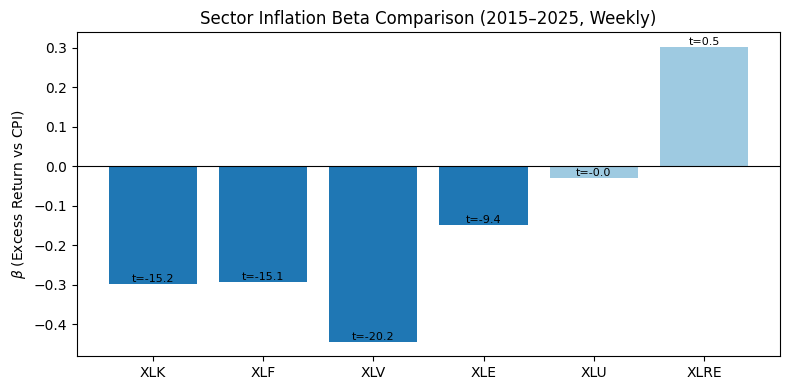

In [ ]:
import matplotlib.pyplot as plt

sectors = ['XLK', 'XLF', 'XLV', 'XLE', 'XLU', 'XLRE']
betas   = [model1.params['re'],
           model2.params['re'],
           model3.params['re'],
           model4.params['re'],
           model5.params['sector_re'],  # fixed
           model6.params['sector_re']]  # fixed

tvals   = [model1.tvalues['re'],
           model2.tvalues['re'],
           model3.tvalues['re'],
           model4.tvalues['re'],
           model5.tvalues['sector_re'],  # fixed
           model6.tvalues['sector_re']]  # fixed

colors = ['#1f77b4' if abs(t) >= 2 else '#9ecae1' for t in tvals]

plt.figure(figsize=(8,4))
bars = plt.bar(sectors, betas, color=colors)
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel(r'$\beta\;(\text{Excess Return vs Interest Rate})$')
plt.title('Sector Inflation Beta Comparison (2015–2025, Weekly)')

for bar, t in zip(bars, tvals):
    height = bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2, height,
             f't={t:.1f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


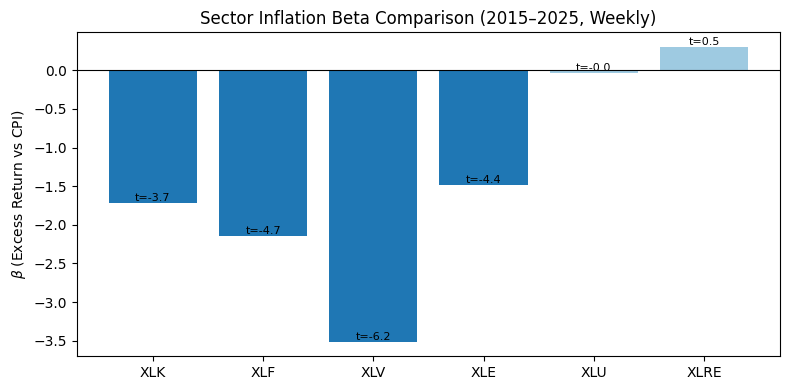

In [ ]:
sectors = ['XLK', 'XLF', 'XLV', 'XLE', 'XLU', 'XLRE']
betas   = [model_1.params['re'],
           model_2.params['re'],
           model_3.params['re'],
           model_4.params['re'],
           model_5.params['sector_re'],  # fixed
           model_6.params['sector_re']]  # fixed

tvals   = [model_1.tvalues['re'],
           model_2.tvalues['re'],
           model_3.tvalues['re'],
           model_4.tvalues['re'],
           model_5.tvalues['sector_re'],  # fixed
           model_6.tvalues['sector_re']]  # fixed

colors = ['#1f77b4' if abs(t) >= 2 else '#9ecae1' for t in tvals]

plt.figure(figsize=(8,4))
bars = plt.bar(sectors, betas, color=colors)
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel(r'$\beta\;(\text{Excess Return vs CPI})$')
plt.title('Sector Inflation Beta Comparison (2015–2025, Weekly)')

for bar, t in zip(bars, tvals):
    height = bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2, height,
             f't={t:.1f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()
